# CSCI-P556, Fall 2018
# Assignment 4

In [36]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import math
from collections import Counter, defaultdict
import matplotlib.pyplot as plot
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC  
from matplotlib.colors import ListedColormap

We will be using the the following data sets in this assignment:



*   [Ionosphere](https://archive.ics.uci.edu/ml/datasets/ionosphere)
*   [Car Evaluation](https://archive.ics.uci.edu/ml/datasets/car+evaluation)
*   [Credit Approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval)

Download them to the same folder as this .ipynb file. Take a look at the 'Data Set Descriptions' links in the above links.


In [2]:
# Code for problem 1 goes here/
Ionosphere=pd.read_table("C:/Users/archi/Desktop/Ionosphere.txt",sep=',',header=None)
car=pd.read_table("C:/Users/archi/Desktop/carData.txt",sep=',',header=None)
credit=pd.read_table("C:/Users/archi/Desktop/credit.txt",sep=',',header=None)

In [3]:
## Converting car to numeric
car.columns=['a','b','c','d','e','f','target']
cleanup_nums = {'a':     {"vhigh": 4, "high": 3,"med": 2,"low": 1},
                'b': {"vhigh": 4, "high": 3,"med": 2,"low": 1},
                'c': {"5more": 5},
                'd': {"more": 5},
                'e': {"small": 1,"med": 2,"big": 3},
                'f': {"low": 1,"med": 2,"high": 3},
                'target' : {"unacc":1, "acc":2, "good":3, "vgood":4 } 
               }
car.replace(cleanup_nums, inplace=True)
car = car.convert_objects(convert_numeric=True)
car2 = car.iloc[:, :-1]
car2 = (car2 - car2.mean()) / (car2.max() - car2.min())

car3 = car.iloc[:,-1]

car= pd.concat([car2, car3], axis=1)
car=car.round(1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if sys.path[0] == '':


In [4]:
#credit=credit.replace('?', np.NAN)
credit=credit.replace('?', np.NaN)
credit.columns=['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','target']

credit['A1'] = credit['A1'].astype('category')
credit['A4'] = credit['A4'].astype('category')

credit['A5'] = credit['A5'].astype('category')
credit['A6'] = credit['A6'].astype('category')

credit['A7'] = credit['A7'].astype('category')
credit['A9'] = credit['A9'].astype('category')

credit['A10'] = credit['A10'].astype('category')
credit['A12'] = credit['A12'].astype('category')
credit['A13'] = credit['A13'].astype('category')
credit['target'] = credit['target'].astype('category')

credit=credit.apply(lambda x: x.fillna(x.mode().ix[0]),axis=0)

cat_columns = credit.select_dtypes(['category']).columns

credit[cat_columns] = credit[cat_columns].apply(lambda x: x.cat.codes)

credit = credit.convert_objects(convert_numeric=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


## Problem 1: K-Fold Cross Validation [10 points]

Implement k- fold cross validation and select k = 5 to create 5 training and 5 test data sets from each data
set and save these 30 files. You will use these data sets for model comparison and parameter selection.

In [5]:
# Code for problem 1 goes here
def k_fold_train(data):
    
    data = data.sample(frac=1).reset_index(drop=True)
    
    k=int(data.shape[0]/5)
    
    train_x1=data.iloc[:k,:]
    train_x2=data.iloc[k:2*k,:]
    train_x3=data.iloc[2*k:3*k,:]
    train_x4=data.iloc[3*k:4*k,:]
    train_x5=data.iloc[4*k:,:]
    
    y1 = train_x1.iloc[:,-1]
    y2 = train_x2.iloc[:,-1]
    y3 = train_x3.iloc[:,-1]
    y4 = train_x4.iloc[:,-1]
    y5 = train_x5.iloc[:,-1]
    
    train_x1 = train_x1.iloc[:, :-1]
    train_x2 = train_x2.iloc[:, :-1]
    train_x3 = train_x3.iloc[:, :-1]
    train_x4 = train_x4.iloc[:, :-1]
    train_x5 = train_x5.iloc[:, :-1]
    
    return(train_x1,train_x2,train_x3,train_x4,train_x5,y1,y2,y3,y4,y5)


Ionosphere_train_x1,Ionosphere_train_x2,Ionosphere_train_x3,Ionosphere_train_x4,Ionosphere_train_x5,Ionosphere_y1,Ionosphere_y2,Ionosphere_y3,Ionosphere_y4,Ionosphere_y5=k_fold_train(Ionosphere)

car_train_x1,car_train_x2,car_train_x3,car_train_x4,car_train_x5,car_y1,car_y2,car_y3,car_y4,car_y5=k_fold_train(car)

credit_train_x1,credit_train_x2,credit_train_x3,credit_train_x4,credit_train_x5,credit_y1,credit_y2,credit_y3,credit_y4,credit_y5=k_fold_train(credit)


## Problem 2: K-Nearest Neighbors (KNN) [30 points]

---



2.1 Implement KNN algorithm with two different distance functions. You can either use an existing distance
functions, i.e., Euclidean or design your own.

In [6]:
# Code for problem 2.1 goes here
cols=[]

def new_fn(data_x2,data_y2,Ionosphere_train_x1,Ionosphere_y1,lim):

    data_x2 = data_x2.reset_index(drop=True)
    y=list(data_y2)
    cols=[]



    appended_data=pd.DataFrame([])
    for i in range(Ionosphere_train_x1.shape[0]):
        distance_diff=data_x2 - Ionosphere_train_x1.iloc[i,:]
        distance_squared = distance_diff**2
        distance = distance_squared.sum(axis=1)**0.5
        
        
        distance_abs=abs(data_x2 - Ionosphere_train_x1.iloc[i,:])
        distance_abs_v2 = distance_abs.sum(axis=1)
        
        distance=pd.DataFrame(distance)
        distance['abs']=distance_abs_v2
        distance['inital']=i
        distance['class']=y
        appended_data=appended_data.append(distance)

    #dist_euclidian = pd.concat(appended_data, axis=1)
    #print(appended_data)
    dist_euclidian=pd.DataFrame(appended_data)
    dist_euclidian.columns=['dist','abs_dist','inital','class']

    dist_euclidian['Rank'] = dist_euclidian.groupby('inital')['dist'].rank(method='first')
    dist_euclidian_v2=dist_euclidian.loc[dist_euclidian["Rank"]<lim+1,]
    dist_euclidian_v3=dist_euclidian_v2.groupby(['inital', 'class']).size().reset_index(name='counts')
    dist_euclidian_v3['Rank'] = dist_euclidian_v3.groupby('inital')['counts'].rank(method='first',ascending=False)
    dist_euclidian_v3=dist_euclidian_v3.loc[dist_euclidian_v3["Rank"]<2,]
    dist_euclidian_v3 = dist_euclidian_v3.reset_index(drop=True)
    Ionosphere_y1=Ionosphere_y1.reset_index(drop=True)
    dist_euclidian_v3['actual']=Ionosphere_y1
    dist_euclidian_v4=dist_euclidian_v3.loc[dist_euclidian_v3["actual"]==dist_euclidian_v3["class"],]
    accuracy_eu=len(dist_euclidian_v4)/len(dist_euclidian_v3)
    
    '''
    dist_euclidian=pd.DataFrame(appended_data)
    print(dist_euclidian.shape)
    dist_euclidian.columns=['dist','abs_dist','inital','class']
    ''' 
    dist_euclidian['Rank'] = dist_euclidian.groupby('inital')['abs_dist'].rank(method='first')
    dist_euclidian_v2=dist_euclidian.loc[dist_euclidian["Rank"]<lim+1,]
    dist_euclidian_v3=dist_euclidian_v2.groupby(['inital', 'class']).size().reset_index(name='counts')
    dist_euclidian_v3['Rank'] = dist_euclidian_v3.groupby('inital')['counts'].rank(method='first',ascending=False)
    dist_euclidian_v3=dist_euclidian_v3.loc[dist_euclidian_v3["Rank"]<2,]
    dist_euclidian_v3 = dist_euclidian_v3.reset_index(drop=True)
    
    dist_euclidian_v3['actual']=Ionosphere_y1
    dist_euclidian_v4=dist_euclidian_v3.loc[dist_euclidian_v3["actual"]==dist_euclidian_v3["class"],]
    accuracy_abs_val=len(dist_euclidian_v4)/len(dist_euclidian_v3)
    
    
    
    return(1-accuracy_eu,1-accuracy_abs_val)

In [7]:
def run_data(data_x1, data_x2,data_x3,data_x4,data_x5,data_y1,data_y2,data_y3,data_y4,data_y5,n):
    
    knn = KNeighborsClassifier(n_neighbors=n)
    
    data_train_X=pd.concat([data_x1, data_x2,data_x3,data_x4])
    data_tain_y=pd.concat([data_y1,data_y2,data_y3,data_y4])
    acc_1,m_acc_1=new_fn(data_train_X,data_tain_y,data_x5,data_y5,n)
    
    
    knn.fit(data_train_X,data_tain_y)
    sk_acc_1=knn.score(data_x5,data_y5)
    
    data_train_X=pd.concat([data_x2, data_x3,data_x4,data_x5])
    data_tain_y=pd.concat([data_y2,data_y3,data_y4,data_y5])
    
    acc_2,m_acc_2=new_fn(data_train_X,data_tain_y,data_x1,data_y1,n)
    knn.fit(data_train_X,data_tain_y)
    sk_acc_2=knn.score(data_x1,data_y1)
 
    data_train_X=pd.concat([data_x1, data_x3,data_x4,data_x5])
    data_tain_y=pd.concat([data_y1,data_y3,data_y4,data_y5])
    
    acc_3,m_acc_3=new_fn(data_train_X,data_tain_y,data_x2,data_y2,n)
    knn.fit(data_train_X,data_tain_y)
    sk_acc_3=knn.score(data_x2,data_y2)
    
    data_train_X=pd.concat([data_x1, data_x2,data_x5,data_x4])
    data_tain_y=pd.concat([data_y1,data_y2,data_y5,data_y4])
    
    acc_4,m_acc_4=new_fn(data_train_X,data_tain_y,data_x3,data_y3,n)
    knn.fit(data_train_X,data_tain_y)
    sk_acc_4=knn.score(data_x3,data_y3)
    
    
    
    data_train_X=pd.concat([data_x1, data_x2,data_x3,data_x5])
    data_tain_y=pd.concat([data_y1,data_y2,data_y3,data_y5])
    
    acc_5,m_acc_5=new_fn(data_train_X,data_tain_y,data_x4,data_y4,n)
    knn.fit(data_train_X,data_tain_y)
    sk_acc_5=knn.score(data_x4,data_y4)
    
    acc_net=(acc_1+acc_2+acc_3+acc_4+acc_5)/5
    
    m_acc_net=(m_acc_1+m_acc_2+m_acc_3+m_acc_4+m_acc_5)/5
    
    sk_acc_net=(sk_acc_1+sk_acc_2+sk_acc_3+sk_acc_4+sk_acc_5)/5
    
    return(acc_net,m_acc_net,sk_acc_net)    


In [8]:
Ionosphere_accuracy=[]

for p in [1,2,3,4,5,6,7,9,8,10,11]:
    acc,acc2,acc3=run_data(Ionosphere_train_x1,Ionosphere_train_x2,Ionosphere_train_x3,Ionosphere_train_x4,Ionosphere_train_x5,Ionosphere_y1,Ionosphere_y2,Ionosphere_y3,Ionosphere_y4,Ionosphere_y5,p)
    Ionosphere_accuracy.append([p,acc,acc2])
    

In [9]:
car_accuracy=[]

for p in [1,2,3,4,5,6,7,8,9,10,11]:
    acc,acc2,acc3=run_data(car_train_x1,car_train_x2,car_train_x3,car_train_x4,car_train_x5,car_y1,car_y2,car_y3,car_y4,car_y5,p)
    car_accuracy.append([p,acc,acc2])
    

In [10]:
credit_accuracy=[]

for p in [1,2,3,4,5,6,7,8,9,10,11]:
    acc,acc2,acc3=run_data(credit_train_x1,credit_train_x2,credit_train_x3,credit_train_x4,credit_train_x5,credit_y1,credit_y2,credit_y3,credit_y4,credit_y5,p)
    credit_accuracy.append([p,acc,acc2])

In [18]:
Ionosphere_accuracy=pd.DataFrame(Ionosphere_accuracy)
Ionosphere_accuracy.columns=['k value','Euclidian','manhattan']
car_accuracy=pd.DataFrame(car_accuracy)
car_accuracy.columns=['k value','Euclidian','manhattan']
credit_accuracy=pd.DataFrame(credit_accuracy)
credit_accuracy.columns=['k value','Euclidian','manhattan']

2.2 Use the data sets obtained in problem 1 to determine the optimal k over each data set for KNN algorithm. For 5 different k values, plot the test error for each data set. Total number of figures = 3 (data set number) × 2 (distance function number) = 6. Report the best k and distance function for each data set.

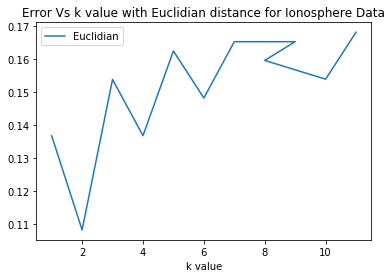

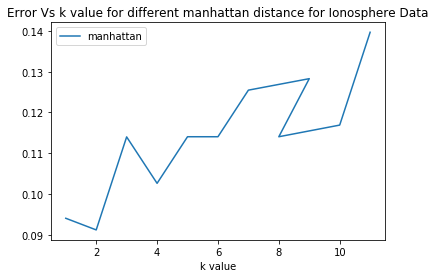

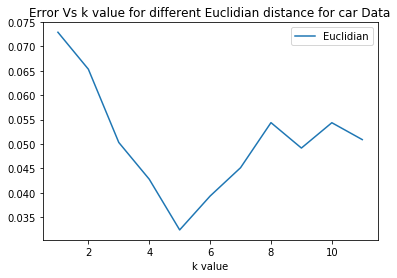

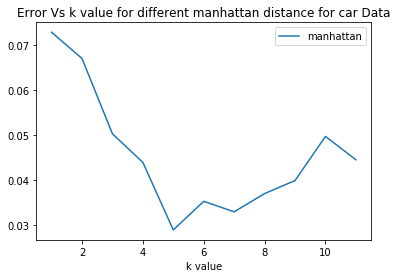

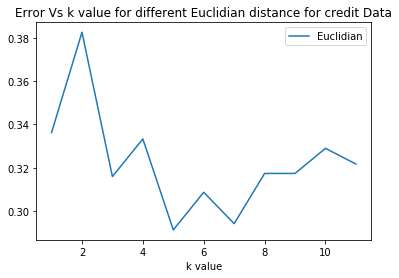

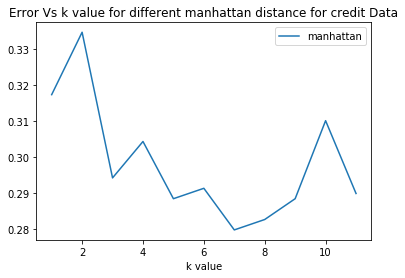

In [93]:
Ionosphere_accuracy.plot(x='k value',y='Euclidian', title='Error Vs k value with Euclidian distance for Ionosphere Data') 
Ionosphere_accuracy.plot(x='k value',y='manhattan', title='Error Vs k value for different manhattan distance for Ionosphere Data') 
car_accuracy.plot(x='k value',y='Euclidian', title='Error Vs k value for different Euclidian distance for car Data') 
car_accuracy.plot(x='k value',y='manhattan', title='Error Vs k value for different manhattan distance for car Data') 
credit_accuracy.plot(x='k value',y='Euclidian', title='Error Vs k value for different Euclidian distance for credit Data') 
credit_accuracy.plot(x='k value',y='manhattan', title='Error Vs k value for different manhattan distance for credit Data') 

In [21]:
Ionosphere_accuracy_v2 = pd.melt(Ionosphere_accuracy, id_vars=["k value"], var_name="Distance Metric", value_name="Error")
car_accuracy_v2 = pd.melt(car_accuracy, id_vars=["k value"], var_name="Distance Metric", value_name="Error")
credit_accuracy_v2 = pd.melt(credit_accuracy, id_vars=["k value"], var_name="Distance Metric", value_name="Error")

print("The maximum accuracy from the Ionosphere data is for the following parameters")
print(Ionosphere_accuracy_v2.loc[Ionosphere_accuracy_v2['Error'].idxmin()])

print("The maximum accuracy from the car data is for the following parameters")
print(car_accuracy_v2.loc[car_accuracy_v2['Error'].idxmin()])

print("The maximum accuracy from the credit data is for the following parameters")

print(credit_accuracy_v2.loc[credit_accuracy_v2['Error'].idxmin()])


The maximum accuracy from the Ionosphere data is for the following parameters
k value                    2
Distance Metric    manhattan
Error              0.0911871
Name: 12, dtype: object
The maximum accuracy from the car data is for the following parameters
k value                    5
Distance Metric    manhattan
Error              0.0289355
Name: 15, dtype: object
The maximum accuracy from the credit data is for the following parameters
k value                    7
Distance Metric    manhattan
Error                0.27971
Name: 17, dtype: object


2.3 Use sklearn's KNN implementation for validation.

In [22]:
# Code for problem 2.3 goes here

from sklearn.grid_search import GridSearchCV   #Performing grid search

knn = KNeighborsClassifier()

parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10],'metric':["euclidean", "manhattan"]}

KNN_Ionosphere = GridSearchCV(knn, param_grid=parameters)
KNN_Ionosphere.fit(Ionosphere.iloc[:,:-1],Ionosphere.iloc[:,-1])

print(KNN_Ionosphere.best_params_)

print("The minimum error using sklearn is",1 - KNN_Ionosphere.best_score_)

{'metric': 'manhattan', 'n_neighbors': 2}
The minimum error using sklearn is 0.11396011396011396


In [23]:
# Code for problem 2.3 goes here

from sklearn.grid_search import GridSearchCV   #Performing grid search

knn = KNeighborsClassifier()

parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10],'metric':["euclidean", "manhattan"]}

KNN_Ionosphere = GridSearchCV(knn, param_grid=parameters)
KNN_Ionosphere.fit(car.iloc[:,:-1],car.iloc[:,-1])

print(KNN_Ionosphere.best_params_)

print("The minimum error using sklearn is",1 - KNN_Ionosphere.best_score_)

{'metric': 'euclidean', 'n_neighbors': 5}
The minimum error using sklearn is 0.10879629629629628


In [24]:
# Code for problem 2.3 goes here

from sklearn.grid_search import GridSearchCV   #Performing grid search

knn = KNeighborsClassifier()

parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11],'metric':["euclidean", "manhattan"]}

KNN_Ionosphere = GridSearchCV(knn, param_grid=parameters)
KNN_Ionosphere.fit(credit.iloc[:,:-1],credit.iloc[:,-1])

print(KNN_Ionosphere.best_params_)

print("The minimum error using sklearn is",1 - KNN_Ionosphere.best_score_)

{'metric': 'manhattan', 'n_neighbors': 7}
The minimum error using sklearn is 0.30434782608695654


## Problem 3: Naive Bayes Classifier [30 points]


3.1 Implement Naive Bayes classifier. You may need to modify it for categorical variables. To handle unseen feature values, you may need to make use Laplace smoothing or the m-estimate of conditional probability method.

In [40]:
# Code for problem 3.1 goes here
def gaussian(val,mn,var):
    val1=1/(2*3.14*var)**0.5
    val2=(((val-mn)**2)/(2*var))
    p=math.exp(-val2) * val1
    return(p)

In [41]:
def naive_bayers(train_x,train_y,test_x,test_y):

    test_x =test_x.reset_index(drop=True)    
    data_x2=train_x.reset_index(drop=True)
    data_y2=train_y.reset_index(drop=True)
    test_x=test_x.reset_index(drop=True)

    train_x=data_x2
    train_y=data_y2
    train_x['Label']=train_y

    aggs= train_x.groupby('Label').agg('mean')
    mean_per_label=pd.DataFrame(aggs)
    mean_per_label += 0.1

    mean_per_label.index.name = 'Label'
    mean_per_label.reset_index(inplace=True)

    aggs= train_x.groupby('Label').agg('var')
    var_per_label=pd.DataFrame(aggs)
    var_per_label+=0.1
    var_per_label.index.name = 'Label'
    var_per_label.reset_index(inplace=True)

    no_of_examples = len(train_y)
    prob = dict(Counter(train_y))
    p=[]
    for key in prob.keys():
            val = prob[key] / float(no_of_examples)
            p.append([key,val])

    cl=pd.DataFrame(p)
    cl.columns=['class','prob_c']

    output=np.unique(train_y)
    p=[]

    for i in output:
        for j in range(test_x.shape[0]):
            prob=1
            for k in range(test_x.shape[1]):
                prob*=gaussian(test_x.ix[j,k],float(mean_per_label.ix[mean_per_label['Label']==i,k+1]),float(var_per_label.ix[var_per_label['Label']==i,k+1]))
            p.append([i,j,prob])

    p=pd.DataFrame(p)
    p.columns=['class','row','prob']
    df = pd.merge(p, cl, how='left', on=['class'])
    df['final']=df['prob']*df['prob_c']
    df['Rank'] = df.groupby('row')['final'].rank(method='first',ascending=False)
    if(len(output)==2):
        v=list(test_y)+list(test_y)
    else:
        v=list(test_y)+list(test_y)+list(test_y)+list(test_y)
    df['actual']=v
    df=df.loc[df["Rank"]==1,]
    df2=df.loc[df["actual"]==df["class"],]
    accuracy_abs_val=len(df2)/len(df)
    return(accuracy_abs_val)

In [115]:
def naive_data(data_x1, data_x2,data_x3,data_x4,data_x5,data_y1,data_y2,data_y3,data_y4,data_y5):
    
    knn = GaussianNB()
    
    data_train_X=pd.concat([data_x1, data_x2,data_x3,data_x4])
    data_tain_y=pd.concat([data_y1,data_y2,data_y3,data_y4])
    acc_1=naive_bayers(data_train_X,data_tain_y,data_x5,data_y5)
    
    knn.fit(data_train_X,data_tain_y)
    sk_acc_1=knn.score(data_x5,data_y5)
    
    data_train_X=pd.concat([data_x2, data_x3,data_x4,data_x5])
    data_tain_y=pd.concat([data_y2,data_y3,data_y4,data_y5])
    
    acc_2=naive_bayers(data_train_X,data_tain_y,data_x1,data_y1)
    knn.fit(data_train_X,data_tain_y)
    sk_acc_2=knn.score(data_x1,data_y1)
    
    
    data_train_X=pd.concat([data_x1, data_x3,data_x4,data_x5])
    data_tain_y=pd.concat([data_y1,data_y3,data_y4,data_y5])
    
    acc_3=naive_bayers(data_train_X,data_tain_y,data_x2,data_y2)
    knn.fit(data_train_X,data_tain_y)
    sk_acc_3=knn.score(data_x2,data_y2)

    
    data_train_X=pd.concat([data_x1, data_x2,data_x5,data_x4])
    data_tain_y=pd.concat([data_y1,data_y2,data_y5,data_y4])
    
    acc_4=naive_bayers(data_train_X,data_tain_y,data_x3,data_y3)
    knn.fit(data_train_X,data_tain_y)
    sk_acc_4=knn.score(data_x3,data_y3)
    
    
    
    data_train_X=pd.concat([data_x1, data_x2,data_x3,data_x5])
    data_tain_y=pd.concat([data_y1,data_y2,data_y3,data_y5])
    
    acc_5=naive_bayers(data_train_X,data_tain_y,data_x4,data_y4)
    knn.fit(data_train_X,data_tain_y)
    sk_acc_5=knn.score(data_x4,data_y4)
    
    acc_net=(acc_1+acc_2+acc_3+acc_4+acc_5)/5
    fold_acc=[acc_1,acc_2,acc_3,acc_4,acc_5]
    sk_acc_net=(sk_acc_1+sk_acc_2+sk_acc_3+sk_acc_4+sk_acc_5)/5
    
    return(acc_net,sk_acc_net,fold_acc)    


3.2 Train Naive Bayes classifiers over training data sets and test each classifier against corresponding test data. Make a plot that shows the error over each test data. Report the average error rate for 5-fold cross validation for each data sets.

In [116]:
# Code for problem 3.2 goes here
Io_acc,Io_acc2,Iono_fold_acc=naive_data(Ionosphere_train_x1,Ionosphere_train_x2,Ionosphere_train_x3,Ionosphere_train_x4,Ionosphere_train_x5,Ionosphere_y1,Ionosphere_y2,Ionosphere_y3,Ionosphere_y4,Ionosphere_y5)
car_acc,car_acc2,Car_fold_acc=naive_data(car_train_x1,car_train_x2,car_train_x3,car_train_x4,car_train_x5,car_y1,car_y2,car_y3,car_y4,car_y5)
Credit_acc,credit_acc2,Credit_fold_acc=naive_data(credit_train_x1,credit_train_x2,credit_train_x3,credit_train_x4,credit_train_x5,credit_y1,credit_y2,credit_y3,credit_y4,credit_y5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


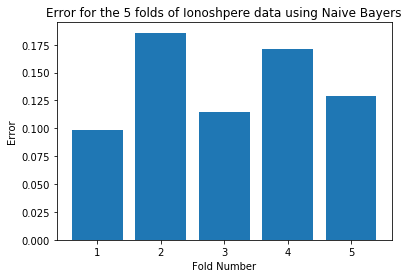

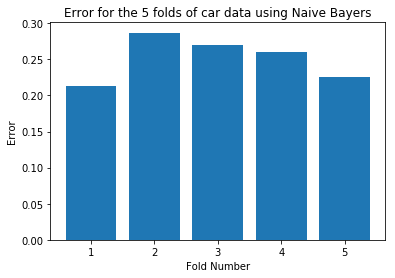

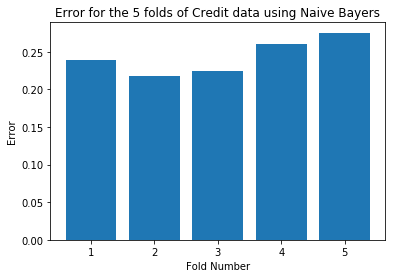

In [258]:
for i in range(len(Iono_fold_acc)):
    Iono_fold_acc[i] = 1 - Iono_fold_acc[i]

for i in range(len(Car_fold_acc)):
    Car_fold_acc[i] = 1-Car_fold_acc[i]

for i in range(len(Credit_fold_acc)):
    Credit_fold_acc[i] = 1-Credit_fold_acc[i]

plot.bar([1,2,3,4,5],Iono_fold_acc)
plot.title("Error for the 5 folds of Ionoshpere data using Naive Bayers")
plot.xlabel("Fold Number")
plot.ylabel("Error")
plot.show()

plot.bar([1,2,3,4,5],Car_fold_acc)
plot.title("Error for the 5 folds of car data using Naive Bayers")
plot.xlabel("Fold Number")
plot.ylabel("Error")
plot.show()

plot.bar([1,2,3,4,5],Credit_fold_acc)
plot.title("Error for the 5 folds of Credit data using Naive Bayers")
plot.xlabel("Fold Number")
plot.ylabel("Error")
plot.show()

In [44]:
print("The Error for the Ionoshpere dataset is ",1-Io_acc)
print("The Error for the car dataset is ",1-car_acc)
print("The Error for the credit dataset is ",1-Credit_acc)


The Error for the Ionoshpere dataset is  0.1397183098591549
The Error for the car dataset is  0.251224387806097
The Error for the credit dataset is  0.24347826086956514


3.3 Use Naive Bayes package in sklearn for validation.

Note : The Gaussian function in sklearn was implented a fews cells on the top, in the below cells we are only calling the error

In [94]:
print("The Error for the Ionoshpere dataset is ",round(1-Io_acc,5)," and its corresponding error from sklearn is",round(1-Io_acc2,5))
print("The Error for the car dataset is ",round(1-car_acc,5),"its corresponding error from sklearn is",round(1-car_acc2,5))
print("The Error for the credit dataset is ",round(1-Credit_acc,5),"its corresponding error from sklearn is",round(1-credit_acc2,5))


The Error for the Ionoshpere dataset is  0.13972  and its corresponding error from sklearn is 0.11388
The Error for the car dataset is  0.25122 its corresponding error from sklearn is 0.2217
The Error for the credit dataset is  0.24348 its corresponding error from sklearn is 0.21159


## Problem 4: Naive Bayes Classifier vs. K-Nearest Neighbors [10 points]

In this question, you are asked to compare Naive Bayes classifier with K-NN algorithm. First, determine the best K-NN model for each data set. Then, make a plot that reveals comparison of two algorithms using test error for each data set. (Total number of figures = 3)

Text(0.5,1,'Comparing the Error from Naive Bayers and KNN for Ionosphere Dataset')

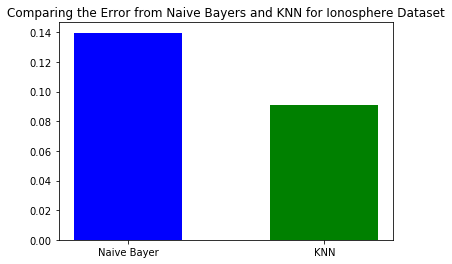

In [56]:
# Code for problem 4 goes here
plot.bar("Naive Bayer", 1-Io_acc, color = 'b', width = 0.55)
plot.bar("KNN", Ionosphere_accuracy_v2.loc[Ionosphere_accuracy_v2['Error'].idxmin(),"Error"], color = 'g', width = 0.55)
plot.title("Comparing the Error from Naive Bayers and KNN for Ionosphere Dataset")

Text(0.5,1,'Comparing the Error from Naive Bayers and KNN for car Dataset')

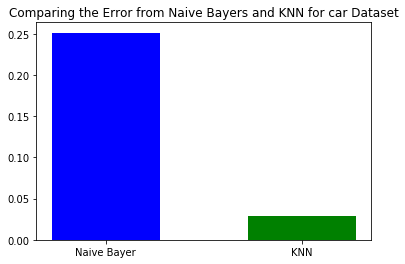

In [57]:
plot.bar("Naive Bayer", 1-round(car_acc,5), color = 'b', width = 0.55)
plot.bar("KNN", car_accuracy_v2.loc[car_accuracy_v2['Error'].idxmin(),"Error"], color = 'g', width = 0.55)
plot.title("Comparing the Error from Naive Bayers and KNN for car Dataset")

Text(0.5,1,'Comparing the Error from Naive Bayers and KNN for car Dataset')

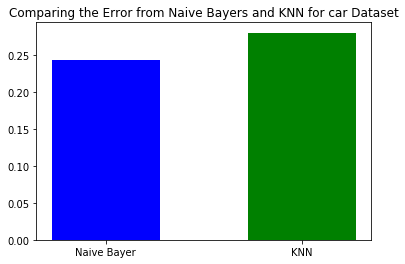

In [61]:
plot.bar("Naive Bayer", 1-round(Credit_acc,5), color = 'b', width = 0.55)
plot.bar("KNN", credit_accuracy_v2.loc[credit_accuracy_v2['Error'].idxmin(),"Error"], color = 'g', width = 0.55)
plot.title("Comparing the Error from Naive Bayers and KNN for car Dataset")

## Problem 5:

In [26]:
from sklearn import svm, datasets
%matplotlib inline
import matplotlib.pyplot as plt

In [176]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

5.1 Create two plots:

1.   One using the sepal length (x-axis) and sepal width (y-axis),
2.   One using the petal length (x-axis) and petal width (y-axis),



Text(0,0.5,'Sepal Width')

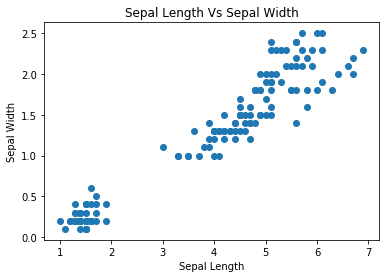

In [213]:
# Code for problem 5.1 goes here
plt.scatter(X[:,0],X[:,1], marker='o')
plt.title('Sepal Length Vs Sepal Width')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')

Text(0,0.5,'Petal Width')

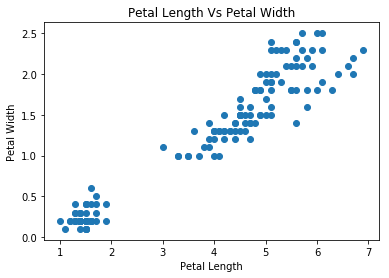

In [178]:
plt.scatter(iris.data[:,2],iris.data[:,3]) 
plt.title('Petal Length Vs Petal Width')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')

5.2 Create a SVM with the following kernels and train it using the sepal features:


1.   SVC with linear kernel (use sklearn's svm.SVC with the kernel parameter 'linear'),
2.   LinearSVC (use sklearn's svm.LinearSVC),
3.   SVC with the RBF kernel,
4.   SVC with a polynomial kernel of degree 3

Plot the decision boundary for each of the four models. Hint: use matplotlib’s contourf and scatter functions. Be sure to label your axes.

In [260]:
# Code for problem 5.2 goes here
X = iris.data[:, :2]
y = iris.target

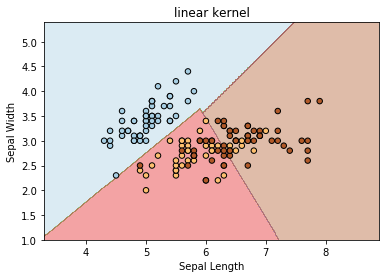

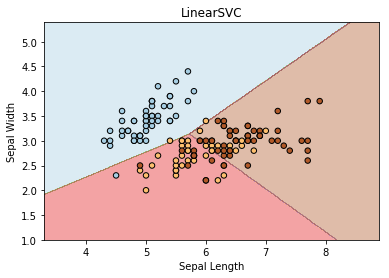

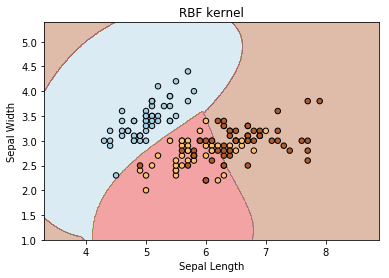

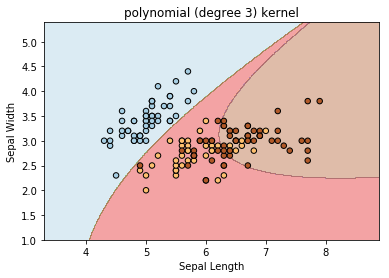

In [262]:
x_val=X[:,0]
y_val=X[:,1]

X=X[:,:2]

x_axis, y_axis = np.meshgrid(np.arange(x_val.min()-1, x_val.max()+1, 0.01),np.arange(y_val.min()-1, y_val.max()+1, 0.01))

###Linear 

svm_linear=svm.SVC(kernel='linear')
svm_linear.fit(X,y)
pred_linear = svm_linear.predict(np.c_[x_axis.ravel(), y_axis.ravel()])
pred_linear1 = pred_linear.reshape(x_axis.shape)

###LinearSVC 
svm_linear=svm.LinearSVC()
svm_linear.fit(X,y)
pred_linear = svm_linear.predict(np.c_[x_axis.ravel(), y_axis.ravel()])
pred_linear2 = pred_linear.reshape(x_axis.shape)



###RBF  
svm_linear=svm.SVC(kernel='rbf', gamma=0.7)
svm_linear.fit(X,y)
pred_linear = svm_linear.predict(np.c_[x_axis.ravel(), y_axis.ravel()])
pred_linear3 = pred_linear.reshape(y_axis.shape)


###Polynomial 
svm_linear= svm.SVC(kernel='poly', degree=3)
svm_linear.fit(X,y)
pred_linear = svm_linear.predict(np.c_[x_axis.ravel(), y_axis.ravel()])
pred_linear4 = pred_linear.reshape(y_axis.shape)


plot.contourf(x_axis, y_axis, pred_linear1,cmap=plt.cm.Paired, alpha=0.4)
plot.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.Paired, s=30, edgecolors='k')
plot.title('Linear kernel')
plot.xlabel('Sepal Length')
plot.ylabel('Sepal Width')
plot.show()

plot.contourf(x_axis, y_axis, pred_linear2,cmap=plt.cm.Paired, alpha=0.4)
plot.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.Paired, s=30, edgecolors='k')
plot.title('LinearSVC')
plot.xlabel('Sepal Length')
plot.ylabel('Sepal Width')
plot.show()

plot.contourf(x_axis, y_axis, pred_linear3,cmap=plt.cm.Paired, alpha=0.4)
plot.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.Paired, s=30, edgecolors='k')
plot.title('RBF kernel')
plot.xlabel('Sepal Length')
plot.ylabel('Sepal Width')
plot.show()

plot.contourf(x_axis, y_axis, pred_linear4,cmap=plt.cm.Paired, alpha=0.4)
plot.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.Paired, s=30, edgecolors='k')
plot.title('polynomial (degree 3) kernel')
plot.xlabel('Sepal Length')
plot.ylabel('Sepal Width')
plot.show()


5.3 Repeat 5.2 using the petal features.

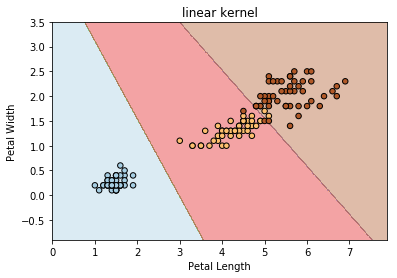

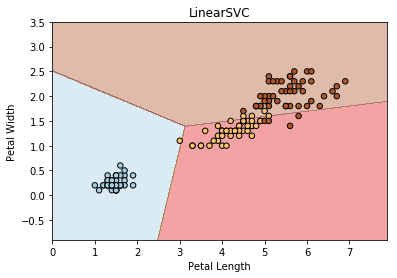

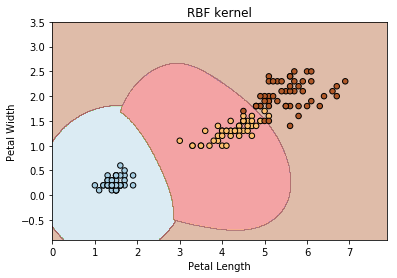

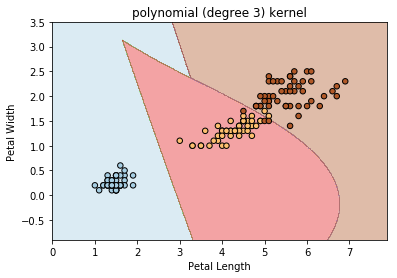

In [264]:
X = iris.data[:, 2:4]
y = iris.target

x_val=X[:,0]
y_val=X[:,1]


x_axis, y_axis = np.meshgrid(np.arange(x_val.min()-1, x_val.max()+1, 0.01),np.arange(y_val.min()-1, y_val.max()+1, 0.01))

###Linear 
svm_linear=svm.SVC(kernel='linear')
svm_linear.fit(X,y)
pred_linear = svm_linear.predict(np.c_[x_axis.ravel(), y_axis.ravel()])
pred_linear1 = pred_linear.reshape(x_axis.shape)

###LinearSVC 
svm_linear=svm.LinearSVC()
svm_linear.fit(X,y)
pred_linear = svm_linear.predict(np.c_[x_axis.ravel(), y_axis.ravel()])
pred_linear2 = pred_linear.reshape(x_axis.shape)



###rbf 
svm_linear=svm.SVC(kernel='rbf', gamma=0.7)
svm_linear.fit(X,y)
pred_linear = svm_linear.predict(np.c_[x_axis.ravel(), y_axis.ravel()])
pred_linear3 = pred_linear.reshape(y_axis.shape)


###poly 
svm_linear= svm.SVC(kernel='poly', degree=3)
svm_linear.fit(X,y)
pred_linear = svm_linear.predict(np.c_[x_axis.ravel(), y_axis.ravel()])
pred_linear4 = pred_linear.reshape(y_axis.shape)


plot.contourf(x_axis, y_axis, pred_linear1,cmap=plt.cm.Paired, alpha=0.4)
plot.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.Paired, s=30, edgecolors='k')
plot.title('linear kernel')
plot.xlabel('Petal Length')
plot.ylabel('Petal Width')
plot.show()

plot.contourf(x_axis, y_axis, pred_linear2,cmap=plt.cm.Paired, alpha=0.4)
plot.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.Paired, s=30, edgecolors='k')
plot.title('LinearSVC')
plot.xlabel('Petal Length')
plot.ylabel('Petal Width')
plot.show()

plot.contourf(x_axis, y_axis, pred_linear3,cmap=plt.cm.Paired, alpha=0.4)
plot.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.Paired, s=30, edgecolors='k')
plot.title('RBF kernel')
plot.xlabel('Petal Length')
plot.ylabel('Petal Width')
plot.show()

plot.contourf(x_axis, y_axis, pred_linear4,cmap=plt.cm.Paired, alpha=0.4)
plot.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.Paired, s=30, edgecolors='k')
plot.title('polynomial (degree 3) kernel')
plot.xlabel('Petal Length')
plot.ylabel('Petal Width')
plot.show()

### Reference

https://www.kaggle.com/arthurtok/decision-boundaries-visualised-via-python-plotly

https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html